In [84]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, LayerNormalization, MultiHeadAttention, GlobalAveragePooling1D
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
from optuna import Trial
from itertools import combinations
import os


# Load Data

In [66]:
# Specify the output directory (adjust the path as needed)
output_directory = 'Documents/ALLAHUAKBAR SKRIPSI BISMILLAH/COBA-COBA/Transformer/0Transformer-Bayesian/1ha'  # Replace with your desired path
if not os.path.exists(output_directory):
    os.makedirs(output_directory)  # Create the directory if it doesn't exist

Station = 'BJMG'

In [68]:
# Load and preprocess your dataset from Excel
file_path = f'C:/Users/USER/Documents/ALLAHUAKBAR SKRIPSI BISMILLAH/Input_Table/Combined/{Station}/{Station}_2years.xlsx'  # Update with your local file path
df = pd.read_excel(file_path, sheet_name='Sheet1',
                   usecols=['WIB','sr_avg','tt_air_max' , 'tt_air_avg', 'Sun_Zenith_Angle'
                            ,'wd_avg','rh_avg' ])

# Filter rows where 'Sun_Zenith_Angle' is below 80
df = df[df['Sun_Zenith_Angle'] < 80]

# Ensure that 'time' column is the index or remove if unnecessary
df['WIB'] = pd.to_datetime(df['WIB'])
df.set_index('WIB', inplace=True)

# Feature Engineering
df['hour'] = df.index.hour
df['month'] = df.index.month
df['DOY'] = df.index.day_of_year


# Show Table Info
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7910 entries, 2022-01-01 07:00:00 to 2023-12-31 17:00:00
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Sun_Zenith_Angle  7910 non-null   float64
 1   wd_avg            7910 non-null   float64
 2   tt_air_max        7910 non-null   float64
 3   tt_air_avg        7910 non-null   float64
 4   rh_avg            7910 non-null   float64
 5   sr_avg            7910 non-null   float64
 6   hour              7910 non-null   int32  
 7   month             7910 non-null   int32  
 8   DOY               7910 non-null   int32  
dtypes: float64(6), int32(3)
memory usage: 525.3 KB


In [69]:
df.head()

,Sun_Zenith_Angle,wd_avg,tt_air_max,tt_air_avg,rh_avg,sr_avg,hour,month,DOY
WIB,,,,,,,,,
2022-01-01 07:00:00,72.39083,213.99,24.615,24.489,98.532,40.061,7,1,1
2022-01-01 08:00:00,58.64536,193.75,27.049,26.837,87.597,231.230,8,1,1
2022-01-01 09:00:00,45.09110,131.06,29.419,29.201,75.733,314.980,9,1,1
2022-01-01 10:00:00,32.15159,207.37,30.499,30.153,70.196,353.260,10,1,1
2022-01-01 11:00:00,21.14215,175.91,32.069,31.546,67.844,514.030,11,1,1


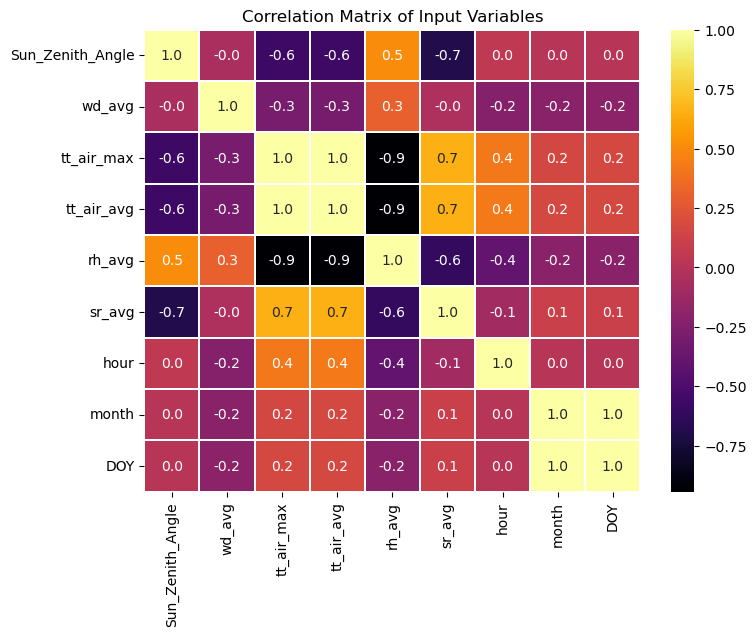

In [70]:
# Correlation Matrix
correlation_matrix = df.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='inferno', linewidths=0.1, fmt=".1f")
plt.title('Correlation MaQtrix of Input Variables')
plt.show()

# Model Bulding

In [38]:
def prepare_data(selected_features, sequence_length=7, horizon=3):  # Change horizon to 3
    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()  # Separate scaler for the target variable

    # Combine 'sr_avg' with selected features
    input_columns = ['sr_avg'] + selected_features

    # Scale input features (selected columns)
    scaled_X = scaler_X.fit_transform(df[input_columns].values)

    # Scale the target variable (sr_avg)
    scaled_y = scaler_y.fit_transform(df[['sr_avg']].values)

    # Create sequences for Transformer
    X, y = [], []
    for i in range(len(scaled_X) - sequence_length - horizon + 1):
        X.append(scaled_X[i:i + sequence_length])
        y.append(scaled_y[i + sequence_length + horizon - 1, 0])

    X, y = np.array(X), np.array(y)

    # Split into training and testing sets (80% training, 20% testing)
    train_size = int(len(X) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    return X_train, X_test, y_train, y_test, scaler_X, scaler_y

all_features = ['tt_air_max' , 'tt_air_avg' , 'Sun_Zenith_Angle','wd_avg',
                'rh_avg','hour', 'month', 'DOY']
feature_combinations = []
for i in range(1, len(all_features) + 1):
    feature_combinations.extend(combinations(all_features, i))


In [40]:
def transformer_model(input_shape, embedding_dim, num_heads, ff_dim):
    inputs = Input(shape=input_shape)
    x = Dense(embedding_dim)(inputs)
    
    # Multi-head attention
    x = MultiHeadAttention(num_heads=num_heads, key_dim=embedding_dim)(x, x)
    x = LayerNormalization(epsilon=1e-6)(x)
    x = Dropout(0.1)(x)
    
    # ```python
    # Feed-forward network
    x = Dense(ff_dim, activation='relu')(x)
    x = Dropout(0.1)(x)
    x = Dense(embedding_dim)(x)
    x = Add()([inputs, x])  # Residual connection
    x = LayerNormalization(epsilon=1e-6)(x)

    outputs = Dense(1)(x)  # Output layer for regression
    model = Model(inputs=inputs, outputs=outputs)
    return model


In [42]:
# Optimize the hyperparameters and input features using Optuna
def objective(trial):
    # Suggest a subset of input features including 'sr_avg'
    selected_features = trial.suggest_categorical('selected_features', feature_combinations)
    selected_features = list(selected_features)  # Convert tuple to list

    # Hyperparameter suggestions for Transformer
    embedding_dim = trial.suggest_categorical('embedding_dim', [32, 64, 128])
    num_heads = trial.suggest_categorical('num_heads', [2, 4, 8])
    ff_dim = trial.suggest_categorical('ff_dim', [64, 128, 256])
    epochs = trial.suggest_int('epochs', 10, 100)
    batch_size = trial.suggest_categorical('batch_size', [32, 64])

    # Prepare data
    X_train, X_test, y_train, y_test, _, _ = prepare_data(['sr_avg'] + selected_features, horizon=3)

    # Define the Transformer model
    model = transformer_model(input_shape=(X_train.shape[1], X_train.shape[2]), 
                              embedding_dim=embedding_dim, 
                              num_heads=num_heads, 
                              ff_dim=ff_dim)

    optimizer = tf.keras.optimizers.Adam()
    model.compile(optimizer=optimizer, loss='mean_squared_error')

    # Early stopping to prevent overfitting
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Train the model
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, 
                        validation_data=(X_test, y_test), verbose=0, 
                        callbacks=[early_stopping])

    # Evaluate the model on the test set
    y_pred = model.predict(X_test)

    # Reshape y_pred to ensure it is 1D
    y_pred = y_pred.reshape(-1)  # Flatten the predictions

    mse = mean_squared_error(y_test, y_pred)

    return mse

In [44]:
# Create Optuna study and optimize
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)


[I 2025-01-15 15:07:11,610] A new study created in memory with name: no-name-0d6f36ad-17ea-4a88-93db-a83386f80df2
C:\Users\USER\anaconda3\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('tt_air_max',) which is of type tuple.
  warnings.warn(message)
C:\Users\USER\anaconda3\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('tt_air_avg',) which is of type tuple.
  warnings.warn(message)
C:\Users\USER\anaconda3\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('Sun_Zenith_Angle',) which is of type tuple.
  warnings.warn(message)
C:\Users\USER\anaconda3\Lib\site-packages\optuna\dis

ValueError: Inputs have incompatible shapes. Received shapes (7, 5) and (7, 128)

# 2

In [74]:
def prepare_data(selected_features, sequence_length=7, horizon=3):
    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()

    input_columns = ['sr_avg'] + selected_features
    scaled_X = scaler_X.fit_transform(df[input_columns].values)
    scaled_y = scaler_y.fit_transform(df[['sr_avg']].values)

    X, y = [], []
    for i in range(len(scaled_X) - sequence_length - horizon + 1):
        X.append(scaled_X[i:i + sequence_length])
        y.append(scaled_y[i + sequence_length + horizon - 1, 0])

    X, y = np.array(X), np.array(y)
    train_size = int(len(X) * 0.8)
    return X[:train_size], X[train_size:], y[:train_size], y[train_size:], scaler_X, scaler_y


In [76]:
def transformer_model(input_shape, embedding_dim, num_heads, ff_dim, d_model):
    inputs = Input(shape=input_shape)
    x = Dense(embedding_dim)(inputs)  # Project input to embedding_dim
    for _ in range(3):  # Use 3 Transformer blocks
        attn_output = MultiHeadAttention(num_heads=num_heads, key_dim=d_model)(x, x)
        attn_output = Dropout(0.1)(attn_output)
        x = LayerNormalization(epsilon=1e-6)(x + attn_output)

        # Align x's last dimension with d_model for residual connection
        ffn_output = Dense(ff_dim, activation='relu')(x)
        ffn_output = Dense(d_model)(ffn_output)
        ffn_output = Dropout(0.1)(ffn_output)
        x = LayerNormalization(epsilon=1e-6)(Dense(d_model)(x) + ffn_output)
        
    x = GlobalAveragePooling1D()(x)
    outputs = Dense(1)(x)
    return Model(inputs, outputs)


In [78]:
def objective(trial):
    selected_features = trial.suggest_categorical('selected_features', feature_combinations)
    selected_features = list(selected_features)

    embedding_dim = trial.suggest_int('embedding_dim', 32, 128, step=16)
    num_heads = trial.suggest_int('num_heads', 2, 8, step=2)
    ff_dim = trial.suggest_int('ff_dim', 32, 128, step=16)
    d_model = trial.suggest_int('d_model', 32, 128, step=16)
    epochs = trial.suggest_int('epochs', 10, 100, step=10)
    batch_size = trial.suggest_categorical('batch_size', [32, 64])

    X_train, X_test, y_train, y_test, _, _ = prepare_data(selected_features, horizon=3)

    model = transformer_model(X_train.shape[1:], embedding_dim, num_heads, ff_dim, d_model)
    model.compile(optimizer=tf.keras.optimizers.Adam(), loss='mean_squared_error')

    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test),
                        epochs=epochs, batch_size=batch_size, verbose=0, callbacks=[early_stopping])

    y_pred = model.predict(X_test)
    return mean_squared_error(y_test, y_pred)

In [80]:
all_features = ['tt_air_max', 'tt_air_avg', 'Sun_Zenith_Angle', 'wd_avg', 'rh_avg', 'hour', 'month', 'DOY']
feature_combinations = [list(comb) for i in range(1, len(all_features) + 1) for comb in combinations(all_features, i)]

In [86]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)

[I 2025-01-15 15:23:40,009] A new study created in memory with name: no-name-eab370a8-5e2b-47ab-a00a-0f8ee7eadfa8
C:\Users\USER\anaconda3\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ['tt_air_max'] which is of type list.
  warnings.warn(message)
C:\Users\USER\anaconda3\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ['tt_air_avg'] which is of type list.
  warnings.warn(message)
C:\Users\USER\anaconda3\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ['Sun_Zenith_Angle'] which is of type list.
  warnings.warn(message)
C:\Users\USER\anaconda3\Lib\site-packages\optuna\distribut

50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


[I 2025-01-15 15:24:50,159] Trial 0 finished with value: 0.02546937630089658 and parameters: {'selected_features': ['wd_avg', 'month', 'DOY'], 'embedding_dim': 112, 'num_heads': 2, 'ff_dim': 48, 'd_model': 112, 'epochs': 30, 'batch_size': 32}. Best is trial 0 with value: 0.02546937630089658.
C:\Users\USER\anaconda3\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ['tt_air_max'] which is of type list.
  warnings.warn(message)
C:\Users\USER\anaconda3\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ['tt_air_avg'] which is of type list.
  warnings.warn(message)
C:\Users\USER\anaconda3\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int

50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


[I 2025-01-15 15:25:48,850] Trial 1 finished with value: 0.021479291599796082 and parameters: {'selected_features': ['tt_air_max', 'rh_avg', 'month', 'DOY'], 'embedding_dim': 32, 'num_heads': 2, 'ff_dim': 112, 'd_model': 96, 'epochs': 80, 'batch_size': 64}. Best is trial 1 with value: 0.021479291599796082.
C:\Users\USER\anaconda3\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ['tt_air_max'] which is of type list.
  warnings.warn(message)
C:\Users\USER\anaconda3\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ['tt_air_avg'] which is of type list.
  warnings.warn(message)
C:\Users\USER\anaconda3\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of 

KeyboardInterrupt: 